#Labwork 3

In [20]:
import numpy as np
from numba import cuda, jit
from time import time
import matplotlib.pyplot as plt

In [11]:
# Load image
img = plt.imread('/content/d2h1o3wqwoe71.jpg')

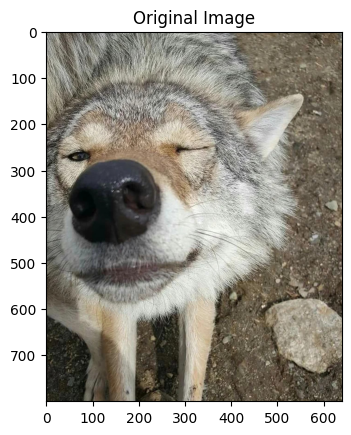

In [12]:
# Display the original image
plt.figure()
plt.imshow(img)
plt.title('Original Image')
plt.show()

In [29]:
def rgb2gray_cpu(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

In [30]:
@cuda.jit
def rgb2gray_cuda(input_image, output_image):
    # Calculate pixel index
    idx = cuda.grid(1)
    if idx < output_image.size:
        r = input_image[idx, 0]
        g = input_image[idx, 1]
        b = input_image[idx, 2]
        # Apply the RGB to grayscale formula
        output_image[idx] = 0.2989 * r + 0.5870 * g + 0.1140 * b

In [32]:
pixelCount = img.shape[0] * img.shape[1]
print(pixelCount)
flat_img = img.reshape(pixelCount, 3).astype(np.float32)
print(flat_img)

512000
[[139. 140. 135.]
 [137. 138. 133.]
 [200. 201. 196.]
 ...
 [ 68.  61.  42.]
 [ 63.  56.  38.]
 [ 58.  51.  33.]]


In [33]:
# Grayscale with CPU
start_cpu = time()  # Start timing
gray_cpu = rgb2gray_cpu(img)
end_cpu = time()  # End timing
print(f"CPU processing time: {end_cpu - start_cpu:.6f} seconds")

CPU processing time: 0.043947 seconds


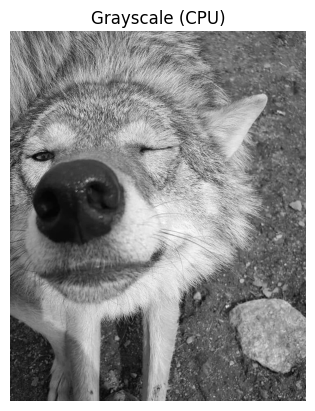

In [36]:
# Display CPU result
plt.imshow(gray_cpu, cmap='gray')
plt.title("Grayscale (CPU)")
plt.axis('off')
plt.show()

In [34]:
# GPU processing
dev_input = cuda.to_device(flat_img)
dev_output = cuda.device_array(pixelCount, dtype=np.float32)

# Config blocks and grids
threads_per_block = 256
blocks_per_grid = (pixelCount + (threads_per_block - 1))

In [35]:
# Grayscale with GPU
start_gpu = time()  # Start timing
rgb2gray_cuda[blocks_per_grid, threads_per_block](dev_input, dev_output)
cuda.synchronize()  # Ensure GPU has completed
end_gpu = time()  # End timing
print(f"GPU processing time: {end_gpu - start_gpu:.6f} seconds")

GPU processing time: 0.002064 seconds


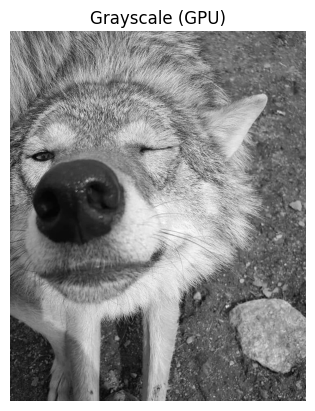

In [38]:
# Copy result back to host
gray_gpu = dev_output.copy_to_host().reshape(img.shape[0], img.shape[1])

# Display GPU result
plt.imshow(gray_gpu, cmap='gray')
plt.title("Grayscale (GPU)")
plt.axis('off')
plt.show()

In [39]:
# Calculate speedup
speedup = (end_cpu - start_cpu) / (end_gpu - start_gpu)
print(f"Speedup: {speedup:.2f}x")

Speedup: 21.29x
